### Singlephotoelectron mini analysis: SPE acceptance

The plugIn for getting the LED data can be find here: https://github.com/XENONnT/straxen/blob/led_plugin/straxen/plugins/led_calibration.py.

The motivation for this analysis is to estimate the SPE acceptance using low-intensity LED runs.

After changing the configuration, the led_calibration plugin will give the amplitude of LED and of the noise. With the spectrums the SPE acceptance will be computed.

In [1]:
%run '/home/gvolta/XENONnT/Initialization/Initialization_for_SPE.py'

0.0.8


In [2]:
st_2 = st.new_context(config=dict(LED_window=(138,188), noise_window=(400, 450)))

In [3]:
runs = st_2.select_runs(run_mode='LED*')

Checking data availability: 100%|██████████| 5/5 [00:17<00:00,  3.73s/it]


In [4]:
run_id = '180219_1049'
data_SPE = st_2.get_array(run_id, 'led_calibration')

In [5]:
run_id = '180219_1049'
data_rr = st.get_array(run_id, 'raw_records', seconds_range=(0,20))

#### LED windows = [138, 188]
#### Noise windwos = [400, 450]

Let's check few random waveforms from different channels in these two windows.

### SPE accepante

- Evan's note: https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:saldanha:xe1t:single_photoelectron_amplitude


In [6]:
def ScalingSpectrum(data, n_channel_s = np.arange(0, 249, 1), ADC_correction = 7):
    
    # In order to subtract out the contribution of the noise to the amplitude spectrum, we will assume that 
    # the fraction of SPE signals with amplitude below a threshold of 5 ADC counts is very small. 
    # We then scale down the off-time amplitude spectrum such that the total counts below the 
    # 5 ADC count threshold is the same as in the LED spectrum.
    
    datatype = [('pmt', np.int16),
                ('spectrumLED', object), ('bins_LED_center', object),
                ('spectrumNOISE', object), ('bins_NOISE_center', object),
                ('spectrumNOISE_scaled', object)]

    SPE = np.zeros((len(n_channel_s)), dtype = datatype)

    for n_channel in tqdm(n_channel_s):
        arr = data[data['channel'] == n_channel]

        LED, bins_LED = np.histogram(arr['amplitudeLED'], bins=150, range=(0,300))
        bins_LED_center = 0.5 * (bins_LED[1:] + bins_LED[:-1])
        noise, bins_noise = np.histogram(arr['amplitudeNOISE'], bins=150, range=(0,300))
        bins_noise_center = 0.5 * (bins_noise[1:] + bins_noise[:-1])

        ADC_correction = 7
        scaling_coeff = LED[:7].sum()/noise[:7].sum()
        noise_scaled = noise*scaling_coeff

        SPE[n_channel]['pmt'] = n_channel
        SPE[n_channel]['spectrumLED'] = LED
        SPE[n_channel]['bins_LED_center'] = bins_LED_center
        SPE[n_channel]['spectrumNOISE'] = noise
        SPE[n_channel]['bins_NOISE_center'] = bins_noise_center
        SPE[n_channel]['spectrumNOISE_scaled'] = noise_scaled
    
    return SPE

In [7]:
SPE = ScalingSpectrum(data = data_SPE)

100%|██████████| 249/249 [01:52<00:00,  2.26it/s]


### We are interested into two value for the SPE acceptance:
1) Looking for the the SPE acceptance at 15 ADC as threshold

2) Looking for the threshold such that the SPE acceptance is 90%

In [8]:
def SPE_acceptance(data, n_channel_s = np.arange(0, 249, 1)):
    
    # The acceptance as a function of amplitude (threshold) is defined as the fraction of 
    # noise-subtracted single photoelectron spectrum above that amplitude.
    
    datatype = [('pmt', np.int16),
                ('Acceptance @ 15 ADC', np.float32),
                ('Threshold for 0.9 acceptance', np.float32),
                ('SPE acceptance', object), ('bins SPE acceptance', object),
                ('noise-subtracted spectrum', object), ('error of noise-subtracted spectrum', object)]

    SPE_acceptance = np.zeros((len(n_channel_s)), dtype = datatype)
    i=0
    for n_channel in tqdm(n_channel_s):
        arr = data[data['pmt'] == n_channel]

        diff = np.absolute(arr['spectrumLED'][0] - arr['spectrumNOISE_scaled'][0])
        sigma_diff = np.sqrt(arr['spectrumLED'][0] + arr['spectrumNOISE_scaled'][0])

        res =  1. - np.cumsum(diff)/np.sum(diff)
        x_center = arr['bins_LED_center'][0]
        pos_15ADC = np.where(x_center<16)
        pos_acc90 = np.where(res<0.9)

        SPE_acceptance[i]['Acceptance @ 15 ADC'] = res[pos_15ADC[0][-1]]
        print(i, pos_15ADC[0][-1], res[pos_15ADC[0][-1]])
        SPE_acceptance[i]['Threshold for 0.9 acceptance'] = x_center[pos_acc90[0][0]]
        print(i, pos_acc90[0][0], x_center[pos_acc90[0][0]], '\n')
        SPE_acceptance[i]['SPE acceptance'] = res
        SPE_acceptance[i]['bins SPE acceptance'] = x_center
        SPE_acceptance[i]['noise-subtracted spectrum'] = diff
        SPE_acceptance[i]['error of noise-subtracted spectrum'] = sigma_diff
        SPE_acceptance[i]['pmt'] = i
        i=i+1
    
    return SPE_acceptance

In [9]:
SPE_acceptance = SPE_acceptance(data = SPE)

100%|██████████| 249/249 [00:00<00:00, 1330.28it/s]

0 7 0.5776605989380323
0 0 1.0 

1 7 0.0004536682362757949
1 0 1.0 

2 7 0.0002875216432285388
2 0 1.0 

3 7 0.6682971169232286
3 0 1.0 

4 7 0.6473542522744653
4 0 1.0 

5 7 0.6099982782338335
5 1 3.0 

6 7 0.6580401046881768
6 0 1.0 

7 7 0.624286076639013
7 0 1.0 

8 7 0.6824971706460508
8 0 1.0 

9 7 0.7688460231835152
9 0 1.0 

10 7 0.7239015549696997
10 0 1.0 

11 7 0.6201474453785132
11 0 1.0 

12 7 7.275985027199727e-05
12 0 1.0 

13 7 0.6007502664636486
13 1 3.0 

14 7 0.6339834543141766
14 1 3.0 

15 7 0.6932846270673765
15 0 1.0 

16 7 0.5460173563002433
16 1 3.0 

17 7 0.7129372798591278
17 0 1.0 

18 7 0.5627352491168803
18 1 3.0 

19 7 0.7021048862944372
19 2 5.0 

20 7 0.5996512703675242
20 0 1.0 

21 7 0.4615680883015737
21 0 1.0 

22 7 0.4625970734333048
22 0 1.0 

23 7 0.3727495090993137
23 0 1.0 

24 7 0.6922973470029662
24 0 1.0 

25 7 0.7237098813607695
25 1 3.0 

26 7 0.0005697432588535056
26 0 1.0 

27 7 0.25102730565180564
27 1 3.0 

28 7 0.7458711063215195
28 1

In [25]:
top_pos_x = []
top_pos_y = []
bot_pos_x = []
bot_pos_y = []
acc_top = []
thr_top = []
acc_bot = []
thr_bot = []
for i in range(0,127):
        top_pos_x.append(PMT_positions[i]['x'])
        top_pos_y.append(PMT_positions[i]['y'])
        acc_top.append(SPE_acceptance[i]['Acceptance @ 15 ADC']*100)
        thr_top.append(SPE_acceptance[i]['Threshold for 0.9 acceptance'])
for i in range(127,248):
        bot_pos_x.append(PMT_positions[i]['x'])
        bot_pos_y.append(PMT_positions[i]['y'])
        acc_bot.append(SPE_acceptance[i]['Acceptance @ 15 ADC']*100)
        thr_bot.append(SPE_acceptance[i]['Threshold for 0.9 acceptance'])

(-52.690000000000005,
 52.690000000000005,
 -53.24317447572439,
 53.24317447572439)

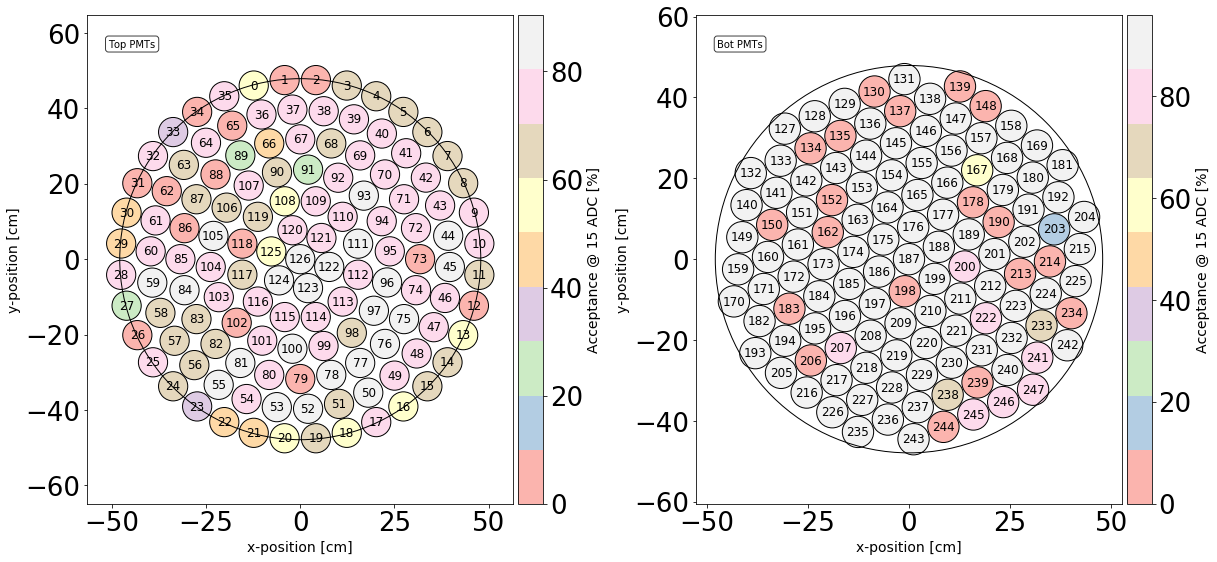

In [32]:
################################# Looking for the the SPE acceptance at 15 ADC as threshold #################################

fig = plt.figure(figsize=(20,9))
###################################################################
plt.subplot(121)

#questo fa solo il disegnino dei PMT
patches = []
for ch in range(0, len(acc_top)):
    circle = Circle((top_pos_x[ch],top_pos_y[ch]), 3.875)
    patches.append(circle)
    plt.annotate(str(ch), xy=(top_pos_x[ch],top_pos_y[ch]), fontsize=12, ha='center', va='center')
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(np.array(acc_top))
#qui plotta la luce che vedono
p.set_clim([min(acc_top),max(acc_top)])

ax = plt.gca()
ax.add_collection(p)
ax.add_collection(PatchCollection([Circle((0,0), 47.9)], 
                                  facecolor='none', edgecolor='black', alpha=1.0))
plt.colorbar(p, ax=ax, pad=0.01, label="Acceptance @ 15 ADC [%]")
ax.text(0.05, 0.95, "Top PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel('x-position [cm]')
plt.ylabel('y-position [cm]')
plt.axis('equal')
###################################################################

###################################################################
plt.subplot(122)

patches = []
for ch in range(0, len(acc_bot)):
    circle = Circle((bot_pos_x[ch],bot_pos_y[ch]), 3.875)
    patches.append(circle)
    plt.annotate(str(ch+127), xy=(bot_pos_x[ch],bot_pos_y[ch]), fontsize=12, ha='center', va='center')
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(np.array(acc_bot))
p.set_clim([min(acc_bot),max(acc_bot)])

ax = plt.gca()
ax.add_collection(p)
ax.add_collection(PatchCollection([Circle((0,0), 47.9)], 
                                  facecolor='none', edgecolor='black', alpha=1.0))
plt.colorbar(p, ax=ax, pad=0.01, label="Acceptance @ 15 ADC [%]")
ax.text(0.05, 0.95, "Bot PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel('x-position [cm]')
plt.ylabel('y-position [cm]')
plt.axis('equal')
###################################################################

(-52.690000000000005,
 52.690000000000005,
 -53.24317447572439,
 53.24317447572439)

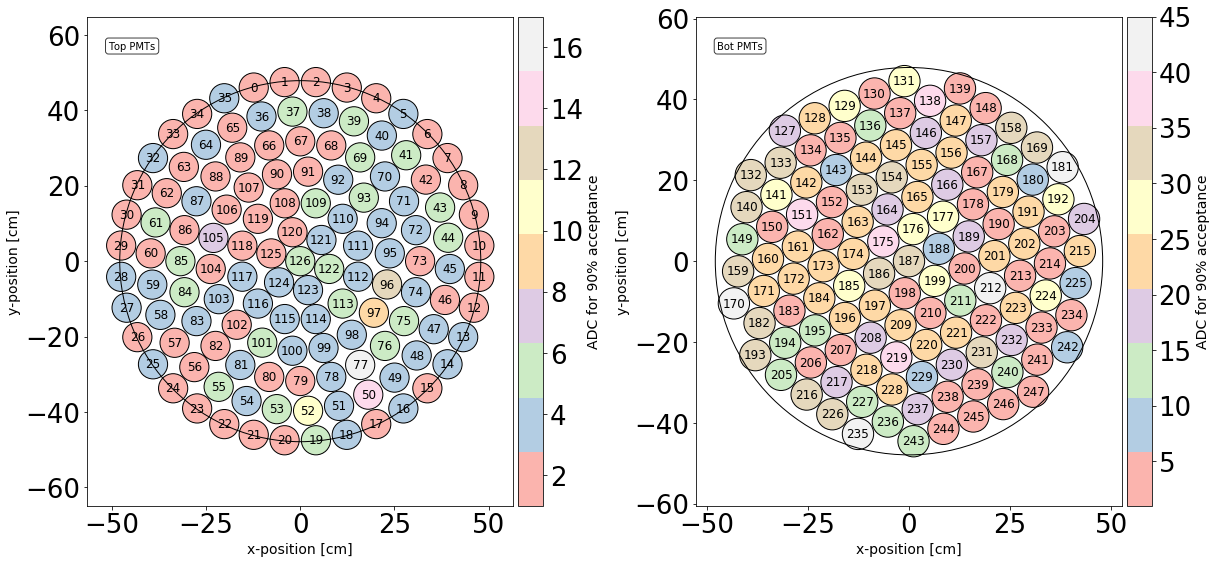

In [33]:
############################### Looking for the threshold such that the SPE acceptance is 90% ###############################

fig = plt.figure(figsize=(20,9))
###################################################################
plt.subplot(121)

#questo fa solo il disegnino dei PMT
patches = []
for ch in range(0, len(thr_top)):
    circle = Circle((top_pos_x[ch],top_pos_y[ch]), 3.875)
    patches.append(circle)
    plt.annotate(str(ch), xy=(top_pos_x[ch],top_pos_y[ch]), fontsize=12, ha='center', va='center')
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(np.array(thr_top))
#for i in range(len(thr_top)):
#    print(i, thr_top[i])
#qui plotta la luce che vedono
p.set_clim([min(thr_top),max(thr_top)])

ax = plt.gca()
ax.add_collection(p)
ax.add_collection(PatchCollection([Circle((0,0), 47.9)], 
                                  facecolor='none', edgecolor='black', alpha=1.0))
plt.colorbar(p, ax=ax, pad=0.01, label="ADC for 90% acceptance")
ax.text(0.05, 0.95, "Top PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel('x-position [cm]')
plt.ylabel('y-position [cm]')
plt.axis('equal')
###################################################################

###################################################################
plt.subplot(122)

patches = []
for ch in range(0, len(thr_bot)):
    circle = Circle((bot_pos_x[ch],bot_pos_y[ch]), 3.875)
    patches.append(circle)
    plt.annotate(str(ch+127), xy=(bot_pos_x[ch],bot_pos_y[ch]), fontsize=12, ha='center', va='center')
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(np.array(thr_bot))
#for i in range(len(thr_bot)):
#    print(i+127, thr_bot[i])
p.set_clim([min(thr_bot),max(thr_bot)])

ax = plt.gca()
ax.add_collection(p)
ax.add_collection(PatchCollection([Circle((0,0), 47.9)], 
                                  facecolor='none', edgecolor='black', alpha=1.0))
plt.colorbar(p, ax=ax, pad=0.01, label="ADC for 90% acceptance")
ax.text(0.05, 0.95, "Bot PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel('x-position [cm]')
plt.ylabel('y-position [cm]')
plt.axis('equal')
###################################################################

### Single PMT watching

No handles with labels found to put in legend.


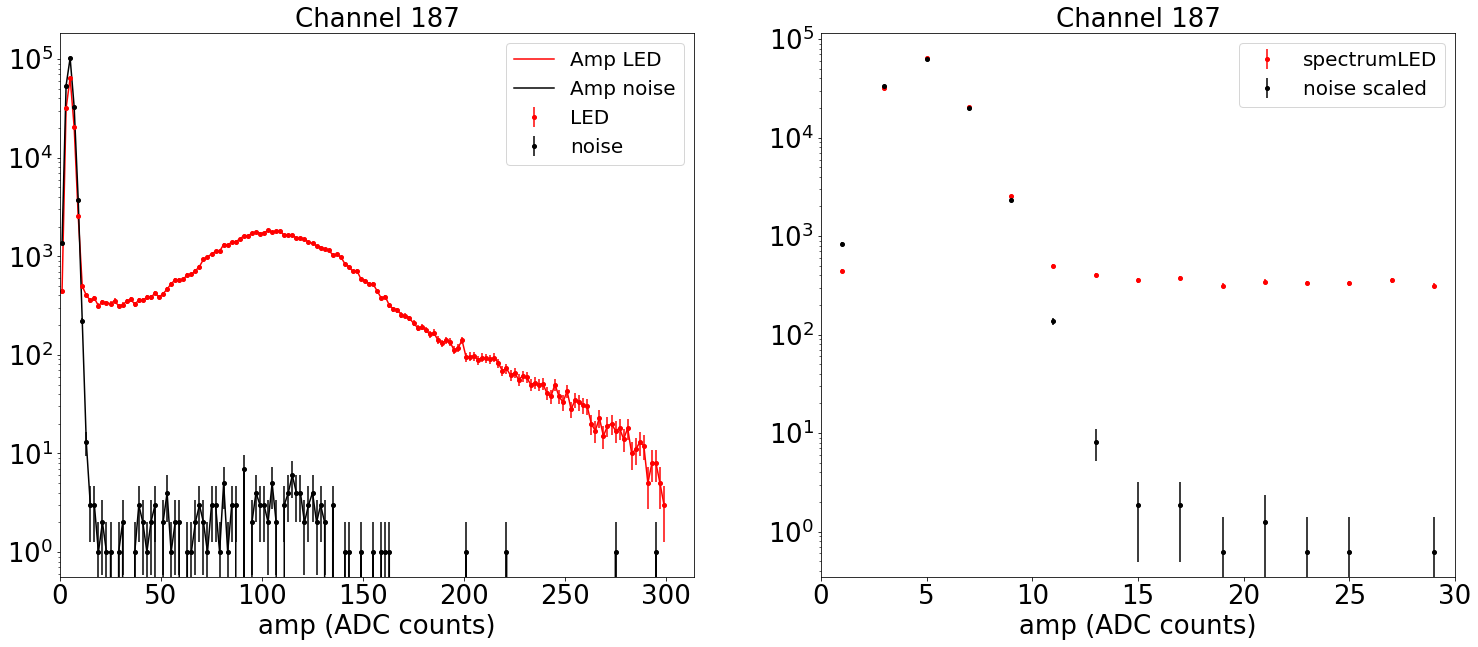

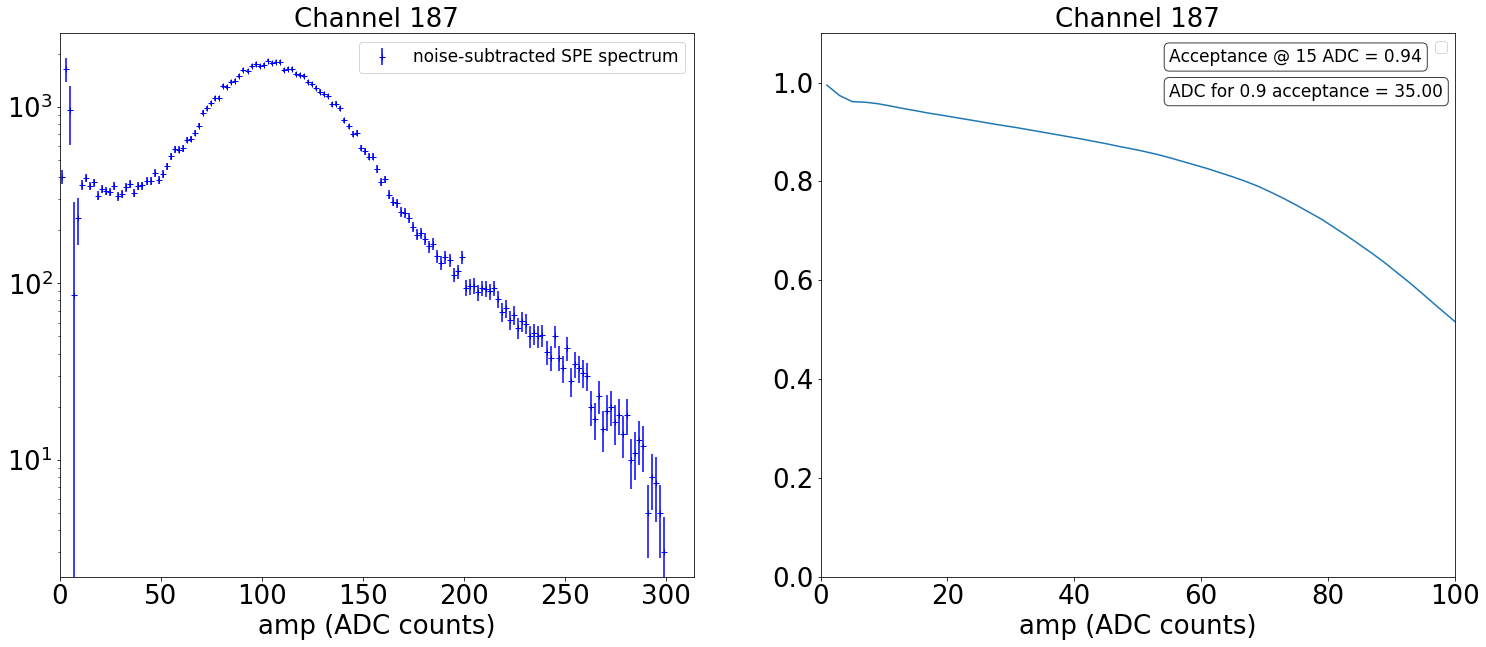

In [34]:
fig = plt.figure(figsize=(25,10))
n_channel = 187

plt.subplot(121)

plt.plot(SPE[SPE['pmt']==n_channel]['bins_LED_center'][0], SPE[SPE['pmt']==n_channel]['spectrumLED'][0], 
         color='r', label='Amp LED')
plt.plot(SPE[SPE['pmt']==n_channel]['bins_NOISE_center'][0], SPE[SPE['pmt']==n_channel]['spectrumNOISE'][0], 
         color='k', label='Amp noise')

plt.errorbar(x = SPE[SPE['pmt']==n_channel]['bins_LED_center'][0], y = SPE[SPE['pmt']==n_channel]['spectrumLED'][0], 
             yerr = np.sqrt(SPE[SPE['pmt']==n_channel]['spectrumLED'][0]), fmt='ro', ms = 4, label='LED')

plt.errorbar(x = SPE[SPE['pmt']==n_channel]['bins_NOISE_center'][0],  y = SPE[SPE['pmt']==n_channel]['spectrumNOISE'][0], 
             yerr = np.sqrt(SPE[SPE['pmt']==n_channel]['spectrumNOISE'][0]), fmt='ko', ms = 4, label='noise')

plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
plt.yscale('log')
plt.legend(loc='best', fontsize=20)
plt.xlim(0)

plt.subplot(122)

plt.errorbar(x = SPE[SPE['pmt']==n_channel]['bins_LED_center'][0], y = SPE[SPE['pmt']==n_channel]['spectrumLED'][0], 
             yerr = np.sqrt(SPE[SPE['pmt']==n_channel]['spectrumLED'][0]), fmt='ro', ms = 4, label='spectrumLED')

plt.errorbar(x = SPE[SPE['pmt']==n_channel]['bins_NOISE_center'][0],  y = SPE[SPE['pmt']==n_channel]['spectrumNOISE_scaled'][0], 
             yerr = np.sqrt(SPE[SPE['pmt']==n_channel]['spectrumNOISE_scaled'][0]), fmt='ko', ms = 4, label='noise scaled')

plt.xlim(left = 0, right=30)
plt.yscale('log')
plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
plt.legend(loc='best', fontsize=20)


fig = plt.figure(figsize=(25,10))

plt.subplot(121)

plt.errorbar(x = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['bins SPE acceptance'][0], 
             y = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['noise-subtracted spectrum'][0], 
             yerr = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['error of noise-subtracted spectrum'][0], 
             fmt='b+', label='noise-subtracted SPE spectrum')

plt.xlim(left = 0)
plt.yscale('log')
plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
plt.legend(loc='best', fontsize=17)

plt.subplot(122)

plt.plot(SPE_acceptance[SPE_acceptance['pmt']==n_channel]['bins SPE acceptance'][0], 
         SPE_acceptance[SPE_acceptance['pmt']==n_channel]['SPE acceptance'][0]) 

plt.text(55, 1.07, 
         'Acceptance @ 15 ADC = %.2f'%(SPE_acceptance[SPE_acceptance['pmt']==n_channel]['Acceptance @ 15 ADC'][0]),
         horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75), 
         fontsize=17)

plt.text(55, 1, 
         'ADC for 0.9 acceptance = %.2f'%(SPE_acceptance[SPE_acceptance['pmt']==n_channel]['Threshold for 0.9 acceptance'][0]), 
         horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75), 
         fontsize=17)

plt.title('Acceptance', fontsize=26)
plt.ylim(0,1.1)
plt.xlim(0, 100)
plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
plt.legend(loc='best', fontsize=15)

plt.show()